In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from itertools import permutations
from itertools import combinations

# Gen some data

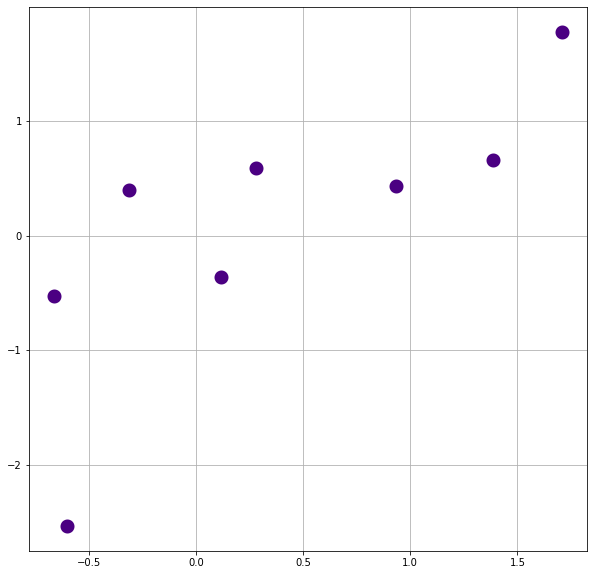

array([[ 0.93093394,  0.43069008],
       [-0.66134901, -0.52653716],
       [ 0.27891139,  0.59103054],
       [-0.60362089, -2.5315631 ],
       [ 1.70601422,  1.77654845],
       [ 1.38392178,  0.66250135],
       [ 0.11885016, -0.3633108 ],
       [-0.3145991 ,  0.39806442]])

In [2]:
data_dim = 2
data_count = 8
data = np.random.randint(data_count, size=(data_count, data_dim))
data = np.unique(data, axis=0)
sample = 'randint'

data = np.random.normal(size=(data_count, data_dim))
sample = 'normal'

plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], color='indigo', linewidth=8)
plt.grid(True)
plt.show()


data

# Radius search functions

In [3]:
def get_edge_radiuses(data, norm=np.linalg.norm):
    """
    Returns radiuses, which are half of distance between verticies
    
    Parameters:
    -------
    data : np.2darray
        Income data, array of verticies.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
    res : Dictionary
        Keys are radiuses, values are lists of vertex pairs.
    """
    distance = data*np.ones([data.shape[0], data.shape[0], data.shape[1]])
    distance = distance - np.transpose(distance, axes=(1, 0, 2))
    distance = norm(distance, axis=2)
    diameters = np.unique(distance[distance!= 0])
    
    res = {}
    for d in diameters:
        r = 0.5*d
        res.update({r : np.where(np.triu(distance) == d)})
        res[r] = list(np.array(res[r]).transpose())
        res[r] = [tuple(i) for i in res[r]]
    return res

In [4]:
edge_radiuses = get_edge_radiuses(data)
len(edge_radiuses.keys())

28

In [5]:
def get_triangle_radius(a, b, c, norm=np.linalg.norm):
    """
    Returns radius of circumscribed circle of triangle.
    
    Parameters:
    -------
    a : np.ndarray
        Vertex
        
    b : np.ndarray
        Vertex
        
    c : np.ndarray
        Vertex
    
    scalar : function
        Dot product of two arrays.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
    r : float
        Radius.
    """
    al = norm(a-b)
    bl = norm(b-c)
    cl = norm(c-a)
    p = 0.5*(al+bl+cl)
    top = al*bl*cl
    bot = 4 * np.sqrt(p*(p-al)*(p-bl)*(p-cl))
    r = top/bot
    return r

In [6]:
def get_triangle_radiuses(data, norm=np.linalg.norm):
    """
    Returns radiuses of circumscribed circle of all triangles
    
    Parameters:
    -------
    data : np.2darray
        Income data, array of verticies.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
    res : Dictionary
        Keys are radiuses, values are lists of vertex triples.
    """
    res = {}
    n = len(data)
    for i in range(n):
        for j in range(i+1, n):
            for k in range(j+1, n):
                r = get_triangle_radius(data[i], data[j], data[k], norm=norm)
                if (r != np.inf) and (r > 0):
                    try:
                        res[r].append((i, j, k))
                    except KeyError:
                        res.update({r : [(i, j, k)]})
    return res

In [7]:
triangle_radiuses = get_triangle_radiuses(data)
len(triangle_radiuses.keys())

56

# Check simplcity status

In [8]:
def get_line_system(a0, a1):
    """
    Returns matrix A and vector b for linear system Ax = b for line contains points a0 and a1.
    
    Parameters:
    -----------
    a0 : np.ndarray
        Vector - point of line.
        
    a1 : np.ndarray
        Vector - point of line.
    
    Returns:
    --------
    A : np.ndarray
        Matrix.
        
    b : np.ndarray
        Vector.
    """
    if len(a0) != len(a1):
        raise ValueError("different dimensions.")
    dim = len(a0)
    A = np.zeros([dim-1, dim])
    b = np.zeros(dim-1)
    for i in range(dim-1):
        j = i+1
        A[i, i] = - (a1[j] - a0[j])
        A[i, j] = + (a1[i] - a0[i])
        b[i] = a1[j]*(a1[i] - a0[i]) - a1[i]*(a1[j] - a0[j])
    return A, b

In [9]:
def segment_intersect(a0, a1, b0, b1):
    """
    Returns True if segments intersects.
    
    Parameters:
    -----------
    a0 : np.ndarray
        Begin of first segment.
        
    a1 : np.ndarray
        End of first segment.
        
    b0 : np.ndarray
        Begin of second segment.
        
    b1 : np.ndarray
        End of second segment.
    
    Returns:
    --------
    result : bool
        Does emgments intersects?
    """
    if (len(a0) != len(a1)) or (len(b0) != len(b1)) or (len(a0) != len(b0)):
        raise ValueError("different dimensions.")
    dim = len(a0)
        
    Aa, va = get_line_system(a0, a1)
    Ab, vb = get_line_system(b0, b1)
    A = np.concatenate([Aa, Ab], axis=0)
    b = np.concatenate([va, vb])
    M = np.concatenate([A, b.reshape(2*dim-2, 1)], axis=1)
    
    if np.linalg.matrix_rank(A) < np.linalg.matrix_rank(M):
        # Случай, когда прямые не пересекаются
        return False
    
    if np.linalg.matrix_rank(A) == np.linalg.matrix_rank(M):
        if np.linalg.matrix_rank(A) < dim:
            # Cлучай, когда прямые совпадают
            j = np.where((a1 - a0) != 0)[0][0]
            ja0, ja1, jb0, jb1 = a0[j], a1[j], b0[j], b1[j]
            if ja1 < ja0:
                ja0, ja1 = ja1, ja0
            if jb1 < jb0:
                jb0, jb1 = jb1, jb0
            return ((ja0 < jb0) and (jb0 < ja1)) or ((jb0 < ja0) and (ja0 < jb1))
        
        if np.linalg.matrix_rank(A) == dim:
            # Cлучай, когда прямые пересекаются
            i = 0
            while np.linalg.matrix_rank(np.concatenate([Aa, Ab[i].reshape(1, dim)], axis=0)) != dim:
                i += 1
            A = np.concatenate([Aa, Ab[i].reshape(1, dim)], axis=0)
            b = np.concatenate([va, [vb[i]]])
            x = np.linalg.solve(A, b)
            ja = np.where((a1 - a0) != 0)[0][0]
            jb = np.where((b1 - b0) != 0)[0][0]
            ja0, ja1, jb0, jb1 = a0[ja], a1[ja], b0[jb], b1[jb]
            if ja1 < ja0:
                ja0, ja1 = ja1, ja0
            if jb1 < jb0:
                jb0, jb1 = jb1, jb0
            return (ja0 < x[ja]) and (x[ja] < ja1) and (jb0 < x[jb]) and (x[jb] < jb1)

In [10]:
def edge_is_new_simplex(data, edge, old_edges=[]):
    """
    Returns True if edge does not intersect old edges
    
    Parameters:
    data : np.ndarray or list of np.ndarrays
        List of points.
    
    edge : tuple or list
        Indices of edge points.
    
    old_edges : list of tuples
        List of old edge indicies
    
    Returns:
    --------
    res : bool
    """
    res = True
    for old in old_edges:
        a0 = data[edge[0]]
        a1 = data[edge[1]]
        b0 = data[old[0]]
        b1 = data[old[1]]
        if segment_intersect(a0, a1, b0, b1):
            res = False
            break
    return res

In [11]:
# Модифицированно с учётом итога. Чуть по-индусски, правда.
def triangle_is_new_simplex(data, triangle, old_edges=[], old_triangles=[]):
    """
    Returns True if triangle borders are old
    
    Parameters:
    data : np.ndarray or list of np.ndarrays
        List of points.
    
    triangle : tuple or list
        Indices of triangle points.
    
    old_edges : list of tuples
        List of old edge indicies
    
    Returns:
    --------
    res : bool
    """
    triangle_sort = np.sort(triangle)
    edges_sort = [tuple(np.sort(edge)) for edge in old_edges]
    res = True
    # Проверяю есть ли у треугольника границы
    res = res and ((triangle_sort[0], triangle_sort[1]) in edges_sort) 
    res = res and ((triangle_sort[0], triangle_sort[2]) in edges_sort) 
    res = res and ((triangle_sort[1], triangle_sort[2]) in edges_sort)
    if res:
        # Проверяю, пересекает ли треугольник рёбра другого треугольника
        """
        triangle_vars = np.array([i for i in permutations(triangle)])
        for old in old_triangles:
            equals = triangle_vars == old
            if (equals.sum(axis=1) == 2).any():
                
                equals = equals[np.where(equals.sum(axis=1) == 2)].reshape(3)
                same = np.array(old)[equals]
                other = np.array(old)[np.logical_not(equals)][0]
                for triangle_edge in combinations(triangle, 2):
                    a0 = data[triangle_edge[0]]
                    a1 = data[triangle_edge[1]]
                    b0 = data[other]
                    for vertex in same:
                        b1 = data[vertex]
                        if segment_intersect(a0, a1, b0, b1):
                            res = False
                            break
        """
        # Написал более читабельную версию. Но результат разный
        for old in old_triangles:
            for new_edge in combinations(triangle, 2):
                for old_edge in combinations(old, 2):
                    if not (np.array(new_edge) == np.array(old_edge)).all():
                        a0 = data[new_edge[0]]
                        a1 = data[new_edge[1]]
                        b0 = data[new_edge[0]]
                        b1 = data[new_edge[1]]
                        if segment_intersect(a0, a1, b0, b1):
                            res = False
                            break
    return res

In [12]:
triangle_is_new_simplex(data, (0, 1, 2), [(0, 1), (1, 2), (0, 2)], [(0, 3, 1)])

True

# Search interesting radiuses

In [13]:
def copy_dict(d):
    """
    Returns copy of dictionary.
    
    Parameters:
    -----------
    d : dict
    
    Returns:
    --------
    r : dict
    """
    r = {}
    for key in d.keys():
        if type(d[key]) == dict:
            r.update({key : copy_dict(d[key])})
        else:
            try:
                r.update({key : d[key].copy()})
            except AttributeError:
                r.update({key : d[key]})
    return r

In [14]:
def get_changing_radiuses(data, edge_radiuses={}, triangle_radiuses={}):
    """
    Returns radiuses which are adding new simplicies.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points.
        
    edge_radiuses : dict
        Keys are radiuses, values are lists of edges
        
    triangle_radiuses : dict
        Keys are radiuses, values are lists of triangles
    
    Returns:
    res : dict
        Keys are radiuses, values are dicts, which keys are dimensions and values are simplicies.
    """
    radiuses = np.unique(np.concatenate([list(edge_radiuses.keys()), list(triangle_radiuses.keys())]))
    simplicies = {1 : [], 2 : []}
    res = {0 : copy_dict(simplicies)}
    for r in radiuses:
        g = False
        if r in edge_radiuses.keys():
            for edge in edge_radiuses[r]:
                if edge_is_new_simplex(data, edge, old_edges=simplicies[1]):
                    g = True
                    try:
                        simplicies[1].append(edge)
                    except KeyError:
                        simplicies.update({1 : [edge]})
        if r in triangle_radiuses.keys():
            for triangle in triangle_radiuses[r]:
                if triangle_is_new_simplex(data, triangle, old_edges=simplicies[1], old_triangles=simplicies[2]):
                    g = True
                    try:
                        simplicies[2].append(triangle)
                    except KeyError:
                        simplicies.update({2 : [triangle]})
                        
        if g:
            res.update({r : copy_dict(simplicies)})
    return res

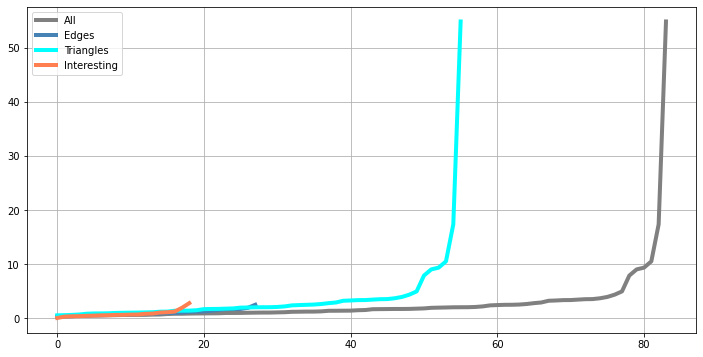

In [15]:
interesting_radiuses = get_changing_radiuses(data, edge_radiuses, triangle_radiuses)

rads_int = np.array(list(interesting_radiuses.keys()))
rads_all = np.unique(np.concatenate([list(edge_radiuses.keys()), list(triangle_radiuses.keys())]))
rads_edg = np.unique(list(edge_radiuses.keys()))
rads_tri = np.unique(list(triangle_radiuses.keys()))

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(rads_all)), rads_all, color='grey', label='All', linewidth=4)
plt.plot(np.arange(len(rads_edg)), rads_edg, color='steelblue', label='Edges', linewidth=4)
plt.plot(np.arange(len(rads_tri)), rads_tri, color='cyan', label='Triangles', linewidth=4)
plt.plot(np.arange(len(rads_int)), rads_int, color='coral', label='Interesting', linewidth=4)

plt.grid(True)
plt.legend()
plt.show()

# Visualizatioan

In [16]:
def draw_balls(data, radius, color='orchid', linewidth=0, alpha=0.5, circle_points=24, fill=True, ax=plt):
    """
    Plots balls arround points from data.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points.
        
    radius : float
        Ball radius.
        
    color : color or rgba tuple
        
    linewidth : scalar
        
    alpha : float
        The alpha blending value, between 0 (transparent) and 1 (opaque).
            
    circle_points : int
        Number of points in circle. (If fill is True, then that will be number of ponts in top and bot arc)
        
    fill : bool
        Fill circle if True.
        
    ax : matplotlib.pyplot or Axes class
    """
    if fill:
        arc_x = radius*np.cos(np.pi*np.arange(circle_points+1)/circle_points)
        arc_y1 = radius*np.sin(np.pi*np.arange(circle_points+1)/circle_points)
        arc_y2 = radius*np.sin(-np.pi*np.arange(circle_points+1)/circle_points)
        for point in data:
            ax.fill_between(x=point[0] + arc_x, y1=point[1] + arc_y1, y2=point[1] + arc_y2,
                            color=color, linewidth=linewidth, alpha=alpha)
    else:
        circle_x = radius*np.cos(2*np.pi*np.arange(circle_points+1)/circle_points)
        circle_y = radius*np.sin(2*np.pi*np.arange(circle_points+1)/circle_points)
        for point in data:
            ax.plot(point[0] + circle_x, point[1] + circle_y, color=color, linewidth=linewidth, alpha=alpha)

In [17]:
def draw_simplicies(data, edges=[], triangles=[],
                    node_color='indigo', node_width=8, node_alpha=1,
                    edge_color='steelblue', edge_width=4, edge_alpha=1,
                    triangle_color='aquamarine', triangle_alpha=0.7, ax=plt):
    """
    Plots nodes edges and triangles of all simplicies.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points (nodes).
            
    edges : list of tuples
        List of node pairs.
            
    triangles : list of tuples
        List of triangle triples.
            
    node_color : color or rgba tuple
        Node color.
            
    node_width : scalar
        Linewidth of nodes.
        
    node_alpha : float
        The alpha blending value for node, between 0 (transparent) and 1 (opaque).

    edge_color : color or rgba tuple
        Edge color.
            
    edge_width : scalar
        Linewidth of edges.
        
    edge_alpha : float
        The alpha blending value for edge, between 0 (transparent) and 1 (opaque).
            
    triangle_color : color or rgba tuple
        Triangle fill color.
        
    node_alpha : float
        The alpha blending value for filled triangle, between 0 (transparent) and 1 (opaque).
        
    ax : matplotlib.pyplot or Axes class
    """
    for triangle in triangles:
        xs = [data[i][0] for i in triangle]
        ys = [data[i][1] for i in triangle]
        ax.fill(xs, ys, color=triangle_color, alpha=triangle_alpha)
    for edge in edges:
        p0 = data[edge[0]]
        p1 = data[edge[1]]
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=edge_color, linewidth=edge_width, alpha=edge_alpha)
    for point in data:
        ax.scatter(point[0], point[1], color=node_color, linewidth=node_width, alpha=node_alpha)

In [18]:
filetemplate = 'simplex'
filename = filetemplate + '_' + sample + '_dim' + str(data_dim) + '_count' + str(data_count)
filename

'simplex_normal_dim2_count8'

In [19]:
radiuses = np.arange(0, int(max(list(interesting_radiuses.keys())))+1.01, 0.05)
print(len(radiuses))
if len(radiuses) > 301:
    raise False

for radius in radiuses:
    r_simplex = np.max(rads_int[rads_int <= radius])
    edges = interesting_radiuses[r_simplex][1]
    trianges = interesting_radiuses[r_simplex][2]
    
    plt.figure(figsize=(12, 12))
    plt.title('$R = ' + str('{:.3f}'.format(radius)) +'$', fontdict={'fontsize':24})
    draw_balls(data, radius, color='orchid', alpha=0.15, ax=plt)
    draw_simplicies(data, edges=edges, triangles=trianges)
    plt.grid(True)
    plt.savefig('pics/' + filename + str(radius).replace('.', '_') + '.png')
    plt.close()

61


In [20]:
images = [imageio.imread('pics/' + filename + str(radius).replace('.', '_') + '.png') for radius in radiuses]
imageio.mimsave(filename + '.gif', images)

__Итог:__ Условие на радиус, что он меньше радиуса описанной вокруг треугольника окружности не достаточно, чтобы считать, что этот треугольник не является симплксом.

__Необходимо ещё:__ При достижении "рёберного" радиуса, не порождающего новое ребро, закрашивать трегольник, ребро которого пересекается потенциальным новым. Нужно модернизивовать функцию triangle_is_new_simplex, добавив переменную "старые треугольники", и проверять, не ту ли у них общих рёбер, и, если есть, проверять, не пересекаются ли необщие.

__Непонятно:__ Всё выше сказанное объясняет, почему не улавливаются некторые треугольники. Но почему не улавливаются некоторые рёбра?

__Дополнение:__ Повозился с triangle_is_new_simplex. Написал два варианта кода. Они выдют разные варианты ответа, но один - нечитабельный. Вероятно, в нём и ошибка. Закомментил. Перепроверить.

Также перепроверить, не начал ли я дополнительные 2-мерные симплексы терять в get_changing_radiuses.

Может быть, в triangle_is_new_simplex выпилить рёберные истории?